# Unsteady flow through a cylinder array at an angle ($Re=200$)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ibmos as ib

## Numerical grid and solver initialization

In [3]:
s1 = ib.stretching(256, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
s2 = ib.stretching(128, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
x = np.r_[-s2[::-1], s1[1:]]

s = ib.stretching(34, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
y = np.r_[-s[::-1], s[1:]]

solver = ib.Solver(x, y, periodic=True, iRe=1/200.0, Co=0.30)

In [4]:
(len(y)-1)/3

22.0

## Immersed boundaries

In [5]:
solver.set_solids(ib.shapes.cylinder("cylinder", 0, 0, 0.5, solver.dxmin))

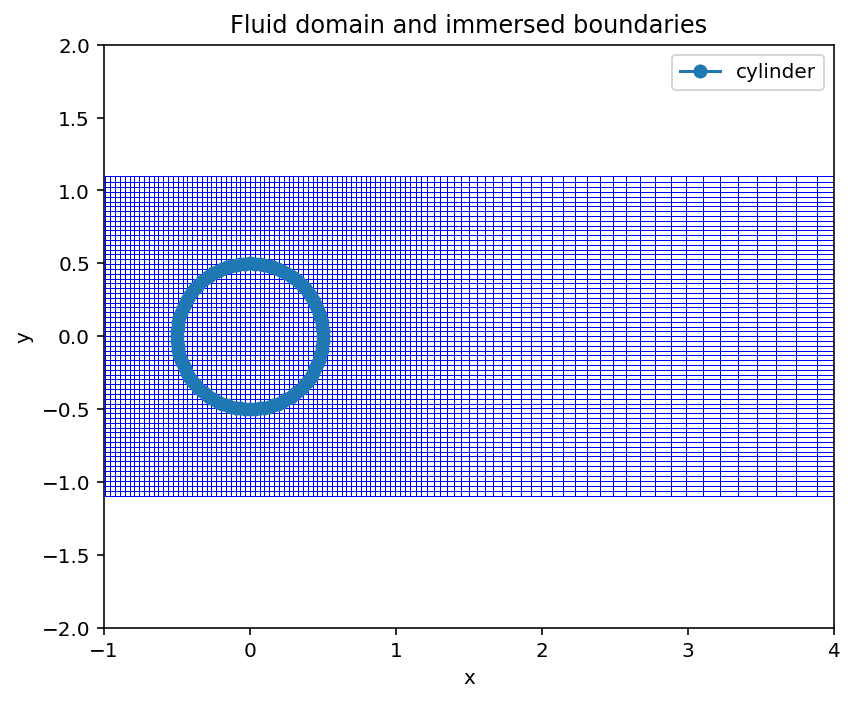

In [6]:
solver.plot_domain(figsize=(6, 5), xlim=(-1, 4), ylim=(-2, 2));

## Boundary conditions

In [7]:
α = 30*np.pi/180

fuBC = (lambda s, t: np.cos(α)*np.ones_like(s),)*2
fvBC = (lambda s, t: np.sin(α)*np.ones_like(s),)*2
fsBC = ((lambda ξ, η, t: np.zeros_like(ξ),)*2 ,)

## Initial condition

In [8]:
u, v, p, *f = solver.reshape(solver.unpack(solver.zero()), p0=0)
c, r, ϵ = -4, 0.5, 0.01
u[:,:] = np.cos(α) - ϵ*solver.fluid.u.y[:,np.newaxis]*np.exp(-((solver.fluid.u.x[np.newaxis,:]-c)**2 + solver.fluid.u.y[:,np.newaxis]**2)/r**2)
v[:,:] = np.sin(α) + ϵ*(solver.fluid.v.x[np.newaxis,:]-c)*np.exp(-((solver.fluid.v.x[np.newaxis,:]-c)**2 + solver.fluid.v.y[:,np.newaxis]**2)/r**2)
x0 = solver.pack(u, v, p, *f)

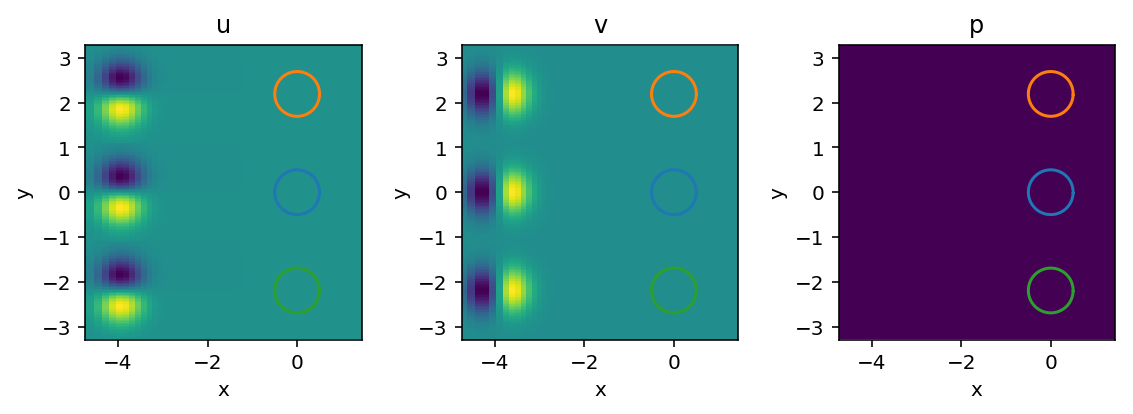

In [9]:
solver.plot_field(x0, xlim=(-4.30, 1), ylim=(-3, 3), repeat=True)

## Unsteady simulation

In [10]:
%%time 
x, t, infodict = solver.steps(x0, fuBC, fvBC, fsBC, outflowEast=True, 
                              saveEvery=int(0.15/solver.dt), number=int(25/solver.dt), verbose=int(2/solver.dt))

Initializing solver...done.
       k            t          x_2       dxdt_2  cylinder_fx  cylinder_fy  Uinf@outlet 
     202  1.99980e+00  2.14511e+02  3.95828e+01  2.79839e+00  2.41977e-01  8.66025e-01 
     404  3.99960e+00  2.05035e+02  7.53916e+01  2.20852e+00  1.85572e+00  8.66025e-01 
     606  5.99940e+00  2.22829e+02  1.00641e+02  3.11937e+00 -2.86879e-02  8.66025e-01 
     808  7.99920e+00  2.04693e+02  9.47278e+01  2.23661e+00  1.48694e+00  8.66025e-01 
    1010  9.99900e+00  2.23030e+02  8.24424e+01  2.84827e+00  1.60550e-01  8.66025e-01 
    1212  1.19988e+01  2.05505e+02  1.18510e+02  2.21354e+00  1.51413e+00  8.66025e-01 
    1414  1.39986e+01  2.22037e+02  9.39263e+01  2.78615e+00  2.44297e-01  8.66025e-01 
    1616  1.59984e+01  2.06252e+02  1.21669e+02  2.21670e+00  1.50679e+00  8.66025e-01 
    1818  1.79982e+01  2.22829e+02  1.00820e+02  2.80561e+00  2.30058e-01  8.66025e-01 
    2020  1.99980e+01  2.06639e+02  1.24716e+02  2.22293e+00  1.49382e+00  8.66025e-01 
    

## Display results

Display velocity field and pressure at the last time step

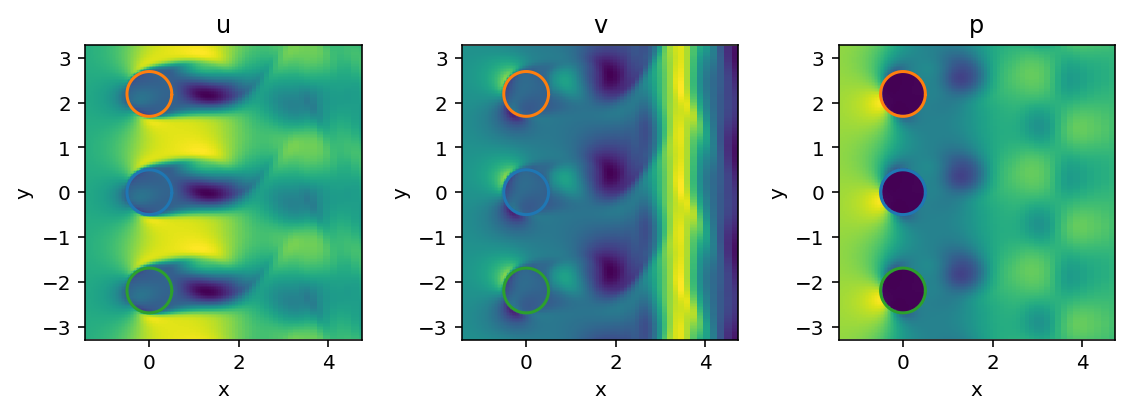

In [11]:
solver.plot_field(x[-1], equal=True, xlim=(-1, 4.3), ylim=(-2, 2), repeat=True);

Temporal evolution of the force coefficients

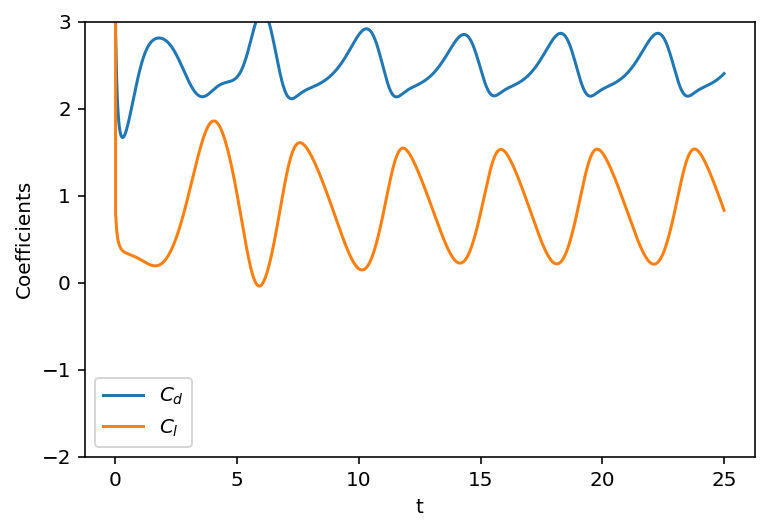

In [12]:
plt.plot(infodict['t'], infodict['cylinder_fx'], label=r'$C_d$')
plt.plot(infodict['t'], infodict['cylinder_fy'], label=r'$C_l$')
plt.ylim(-2, 3)
plt.xlabel('t')
plt.ylabel('Coefficients')
plt.legend();

Animation

In [13]:
from IPython.display import HTML
from matplotlib import animation
%config InlineBackend.figure_format = 'png'

<Figure size 432x288 with 0 Axes>

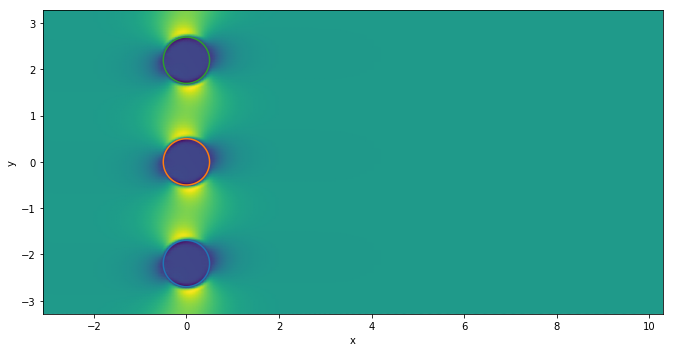

In [14]:
plt.figure()
fig, ax = plt.subplots(figsize=(9.5, 5))
Ly = (y[-1]-y[0])
quad = ax.pcolormesh(solver.fluid.u.x, 
                     np.r_[solver.fluid.u.y - Ly, solver.fluid.u.y, solver.fluid.u.y + Ly],
                     np.vstack([solver.reshape(solver.unpack(x[0]), p0=0)[0],]*3),
                     rasterized=True, shading='gouraud')

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η-Ly)
    plt.plot(solid.ξ, solid.η)
    plt.plot(solid.ξ, solid.η+Ly)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2.8, 10)
ax.set_ylim(-2, 2)
fig.tight_layout()

In [15]:
def init():
    quad.set_array([])
    return quad,

def animate(i):
    array = np.r_[solver.unpack(x[i])[0].ravel(),
                  solver.unpack(x[i])[0].ravel(),
                  solver.unpack(x[i])[0].ravel()]
    quad.set_array(array)
    return quad,

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(x), interval=15, blit=True)

In [16]:
%time HTML(anim.to_html5_video())

CPU times: user 46.4 s, sys: 128 ms, total: 46.5 s
Wall time: 46.9 s
